In [15]:
import tushare as ts
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [3]:
pro = ts.pro_api(token='2cb7b30105056801542e9ff02a8370c509b84397686c94376801c170')
hs300 = pro.index_weight(index_code='000300.SH', start_date='20220301', end_date='20220331')

In [5]:
df = pd.DataFrame()
for ts_code in hs300.con_code.tolist():
    data = pro.daily(ts_code=ts_code, start_date='20220301', end_date='20220331')
    df = pd.concat([df, data], ignore_index=True)

df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')
df = df.sort_values(by='trade_date', ascending=True)

df_basic = pro.daily_basic(ts_code=','.join(hs300.con_code.tolist()), trade_date='20220331',
                            fields='ts_code,trade_date,pe,pb,total_mv')

df_basic['trade_date'] = pd.to_datetime(df_basic['trade_date'])

In [6]:
df_merged = pd.merge(df, df_basic, on=['ts_code', 'trade_date'], how='left')
df_merged = df_merged.dropna(subset=['pe', 'pb', 'total_mv'])
df_merged['eps'] = df_merged['close'] / df_merged['pe']
df_merged['circ_mv'] = df_merged['total_mv'] / df_merged['pb']
df_merged = df_merged.sort_values(by=['eps', 'circ_mv'], ascending=False)
print(df_merged)

         ts_code trade_date     open     high      low    close  pre_close  \
13405  600519.SH 2022-03-31  1720.00  1738.60  1708.80  1719.00    1730.10   
13555  600519.SH 2022-03-31  1720.00  1738.60  1708.80  1719.00    1730.10   
13318  688169.SH 2022-03-31   572.20   584.58   552.96   554.16     574.80   
13740  688169.SH 2022-03-31   572.20   584.58   552.96   554.16     574.80   
13476  300677.SZ 2022-03-31    46.91    47.88    45.97    46.24      46.97   
...          ...        ...      ...      ...      ...      ...        ...   
13538  000301.SZ 2022-03-31    14.53    14.53    14.13    14.20      14.59   
13281  688126.SH 2022-03-31    22.60    22.60    21.90    21.93      22.63   
13762  688126.SH 2022-03-31    22.60    22.60    21.90    21.93      22.63   
13288  600010.SH 2022-03-31     2.25     2.26     2.23     2.23       2.25   
13546  600010.SH 2022-03-31     2.25     2.26     2.23     2.23       2.25   

       change  pct_chg         vol       amount        pe      

In [7]:
group_num = 10
group_size = len(df_merged) // group_num

# 将时间序列数据转换为输入特征
def time_series_to_features(df, time_steps):
    features = []
    for i in range(time_steps, len(df)):
        features.append(df[i-time_steps:i, 0])
    return np.array(features)

# 对数据进行标准化处理
X = df_merged[['eps', 'circ_mv']].values
scaler = StandardScaler()
X = scaler.fit_transform(X[:, [0]])

# 将数据转换为时间序列形式
time_steps = 30
X_ts = time_series_to_features(X, time_steps)
y_ts = df_merged['pct_chg'].values[time_steps:]

In [8]:
# 划分训练集和测试集
train_size = int(len(X_ts) * 0.8)
X_train, X_test = X_ts[:train_size], X_ts[train_size:]
y_train, y_test = y_ts[:train_size], y_ts[train_size:]

In [9]:
# 建立 RNN 模型
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_ts.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# 将输入数据reshape成LSTM模型需要的形状
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [10]:
# 训练模型
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
14/14 [==============================] - 4s 76ms/step - loss: 4.1478 - val_loss: 2.2516
Epoch 2/50
14/14 [==============================] - 0s 22ms/step - loss: 3.9698 - val_loss: 2.1628
Epoch 3/50
14/14 [==============================] - 0s 23ms/step - loss: 3.9621 - val_loss: 2.1290
Epoch 4/50
14/14 [==============================] - 0s 22ms/step - loss: 3.9347 - val_loss: 2.1317
Epoch 5/50
14/14 [==============================] - 0s 22ms/step - loss: 3.9224 - val_loss: 2.1360
Epoch 6/50
14/14 [==============================] - 0s 22ms/step - loss: 3.9089 - val_loss: 2.1341
Epoch 7/50
14/14 [==============================] - 0s 22ms/step - loss: 3.9195 - val_loss: 2.1263
Epoch 8/50
14/14 [==============================] - 0s 27ms/step - loss: 3.9460 - val_loss: 2.1240
Epoch 9/50
14/14 [==============================] - 0s 24ms/step - loss: 3.9095 - val_loss: 2.1432
Epoch 10/50
14/14 [==============================] - 0s 22ms/step - loss: 3.9164 - val_loss: 2.1233
Epoch 11/

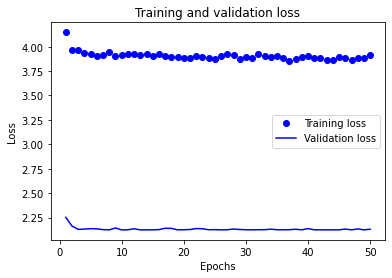

In [11]:
# 可视化训练集和验证集上的损失变化
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# # 预测测试集数据
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred).ravel()

# 预测结果
print('预测结果y_pre=',sep=' ',end=' ')
print(y_pred)

预测结果y_pre= [-0.17859417 -0.17981356 -0.18105942 -0.18230027 -0.18352073 -0.18470174
 -0.18583304 -0.18690127 -0.18789881 -0.18881911 -0.1896643  -0.19043523
 -0.19113141 -0.1917544  -0.19234973 -0.19294399 -0.19355863 -0.19419831
 -0.1948629  -0.19554383 -0.1962629  -0.19702405 -0.1978243  -0.19865137
 -0.19950348 -0.20036858 -0.20126647 -0.20219582 -0.20314902 -0.20410961
 -0.20506102 -0.20598501 -0.20689183 -0.20778304 -0.20867544 -0.20957392
 -0.21048778 -0.21141416 -0.21234566 -0.21326917 -0.21419388 -0.21511704
 -0.21603006 -0.21691912 -0.2177723  -0.21857983 -0.219333   -0.22002453
 -0.22065979 -0.22124356 -0.22178239 -0.22228235 -0.2227661  -0.22324437
 -0.22374004 -0.2242629  -0.2248159  -0.22539562 -0.22600192 -0.22662777
 -0.22727722 -0.22794443 -0.22862095 -0.22929543 -0.23001271 -0.23079187
 -0.23163205 -0.23251969 -0.23344499 -0.23439103 -0.23534971 -0.23630887
 -0.23725408 -0.23817128 -0.23907012 -0.2399525  -0.24081844 -0.24166077
 -0.2424807  -0.24327415 -0.24403661 -0.

In [13]:
# 进行测试
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# 计算R方值
r2 = r2_score(y_test, y_pred)
print('R方值:', r2)

R方值: -0.002287786231036204


In [14]:
# 计算每组收益率
df_merged['y_pred'] = np.nan
df_merged.iloc[-len(y_pred):, df_merged.columns.get_loc('y_pred')] = y_pred.reshape(1, -1)[0]
df_merged['group'] = pd.qcut(df_merged['eps']*df_merged['circ_mv'], group_num, labels=False)
grouped = df_merged.groupby('group')
group_ret = grouped['pct_chg'].mean()

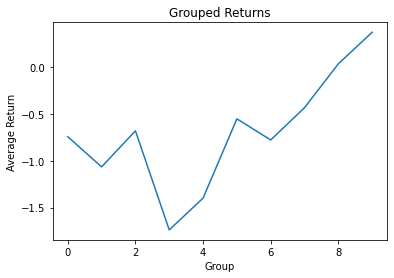

In [16]:
# 可视化回测结果
plt.plot(group_ret.index, group_ret.values)
plt.title('Grouped Returns')
plt.xlabel('Group')
plt.ylabel('Average Return')
plt.show()

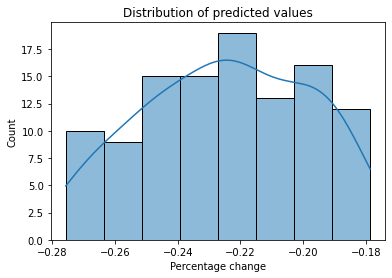

In [17]:
# 可视化模型预测结果的分布
sns.histplot(y_pred, kde=True)
plt.title('Distribution of predicted values')
plt.xlabel('Percentage change')
plt.show()

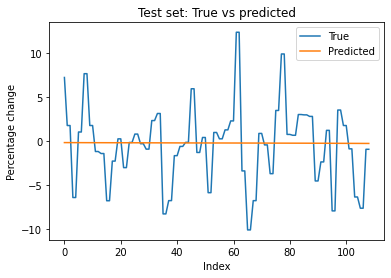

In [18]:
# 可视化预测结果和真实值的对比
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('Test set: True vs predicted')
plt.xlabel('Index')
plt.ylabel('Percentage change')
plt.legend()
plt.show()

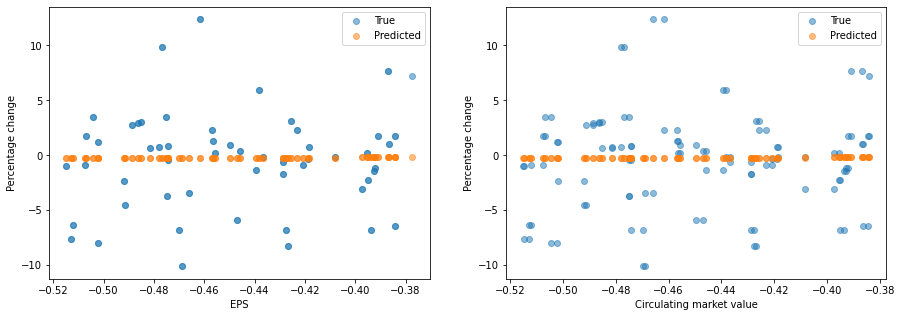

In [19]:
# 可视化预测结果与输入特征之间的关系
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].scatter(X_test[:, 0], y_test, alpha=0.5)
axs[0].scatter(X_test[:, 0], y_pred, alpha=0.5)
axs[0].set_xlabel('EPS')
axs[0].set_ylabel('Percentage change')
axs[0].legend(['True', 'Predicted'])
axs[1].scatter(X_test[:, 1], y_test, alpha=0.5)
axs[1].scatter(X_test[:, 1], y_pred, alpha=0.5)
axs[1].set_xlabel('Circulating market value')
axs[1].set_ylabel('Percentage change')
axs[1].legend(['True', 'Predicted'])
plt.show()